In [140]:
import numpy as np
import matplotlib.pyplot as plt
import lightfm as fm
import lightfm.datasets
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from surprise.prediction_algorithms.matrix_factorization import SVD, SVDpp
import pandas as pd
import surprise
from scipy.sparse import coo_matrix

In [243]:
D=fm.datasets.movielens.fetch_movielens("Dane",genre_features=True, min_rating=3.0)

In [244]:
D

{'train': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 74627 stored elements in COOrdinate format>,
 'test': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 7893 stored elements in COOrdinate format>,
 'item_features': <1682x1701 sparse matrix of type '<class 'numpy.float32'>'
 	with 4575 stored elements in Compressed Sparse Row format>,
 'item_feature_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'genre:Thriller', 'genre:War', 'genre:Western'], dtype=object),
 'item_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object)}

In [245]:
model=fm.LightFM(no_components=15,loss="warp")

In [246]:
%%time
model.fit(D['train'], item_features=D['item_features'], num_threads=4, epochs=20, verbose=True)

Epoch: 100%|██████████| 20/20 [00:01<00:00, 13.83it/s]

CPU times: user 5.3 s, sys: 42.7 ms, total: 5.34 s
Wall time: 1.45 s


In [247]:
np.mean(auc_score(model, D['test'],item_features=D['item_features'], num_threads=4))

0.91570127

In [248]:
np.mean(precision_at_k(model, D['test'], item_features=D['item_features'], num_threads=4))

0.09872747

In [249]:
np.mean(recall_at_k(model, D['test'], item_features=D['item_features'], num_threads=4))

0.12090087360500934

### Surprice datasets

In [228]:
def returnPrecision(org, pred):
    meanScore=0
    for i in range(org.shape[0]):
        localScore=0
        for j in org[i,:]:
            if j in pred[i,:]:
                localScore+=1
        localScore/=len(org[i,:])
        meanScore+=localScore
    return meanScore/org.shape[0]

In [166]:
df=pd.DataFrame(np.array([D['train'].row, D['train'].col, D['train'].data]).T)

In [182]:
surTrainset=surprise.Dataset.load_from_df(df,surprise.reader.Reader()).build_full_trainset()

In [185]:
dfTest=pd.DataFrame(np.array([D['test'].row, D['test'].col, D['test'].data]).T)

In [186]:
surTestset=surprise.Dataset.load_from_df(dfTest,surprise.reader.Reader()).build_full_trainset()

In [303]:
denseTestset=D['test'].toarray()
denseTrain=D['train'].toarray()

### SVD

In [230]:
modelSvd=SVD()

In [231]:
%%time
modelSvd=modelSvd.fit(surTrainset)

CPU times: user 5.06 s, sys: 0 ns, total: 5.06 s
Wall time: 5.07 s


In [232]:
orgBest=np.argpartition(denseTestset, -10)[:,-10:]

In [233]:
predictedTestset=np.zeros_like(denseTestset)

In [234]:
for x,y in zip(D['test'].row, D['test'].col):
    predictedTestset[x,y]=modelSvd.predict(x,y).est

In [235]:
presBest=np.argpartition(predictedTestset, -10)[:,-10:]

In [236]:
returnPrecision(orgBest, presBest)

0.9611876988335052

### SVD++

In [238]:
%%time
modelSvdpp=SVDpp()
modelSvdpp=modelSvdpp.fit(surTrainset)

CPU times: user 3min 17s, sys: 447 ms, total: 3min 18s
Wall time: 3min 18s


In [241]:
orgBest=np.argpartition(denseTestset, -10)[:,-10:]
predictedTestset=np.zeros_like(denseTestset)
for x,y in zip(D['test'].row, D['test'].col):
    predictedTestset[x,y]=modelSvdpp.predict(x,y).est
presBest=np.argpartition(predictedTestset, -10)[:,-10:]

In [242]:
returnPrecision(orgBest, presBest)

0.9612937433722116

# b

In [268]:
import sklearn.metrics

In [254]:
D['item_features'].toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [275]:
mask=(D['item_features'].toarray()[:,-1]==1)
mask2=(D['item_features'].toarray()[:,-2]==1)

In [276]:
itemEmbed=model.get_item_representations(D['item_features'].toarray()[mask])[1]
itemEmbed2=model.get_item_representations(D['item_features'].toarray()[mask2])[1]

In [280]:
allItemEmbeded=np.concatenate([itemEmbed, itemEmbed2], axis=0)

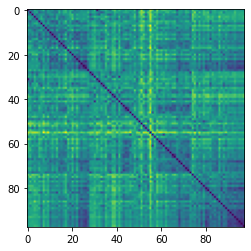

In [281]:
plt.imshow(sklearn.metrics.euclidean_distances(allItemEmbeded))

# c

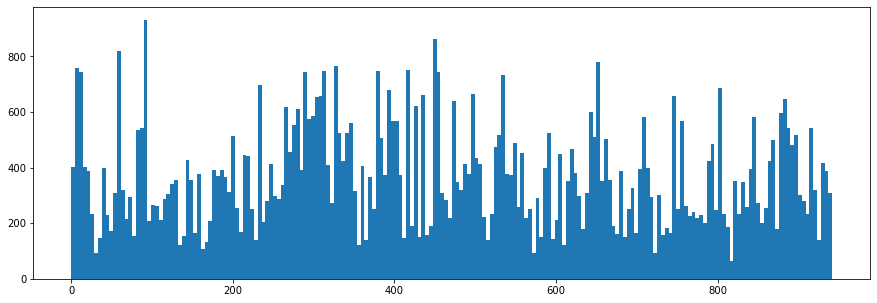

In [318]:
plt.gcf().set_size_inches((15,5))
plt.hist(D['train'].row,bins=200)
plt.show()

##### Ograniczenie do 30 ocen

In [304]:
longHistUsers=np.arange(denseTrain.shape[0])[np.sum((denseTrain>0), axis=1)>30]

denseTestset[longHistUsers,:]=0

shortUsers=coo_matrix(denseTestset)

In [310]:
np.mean(auc_score(model, shortUsers,item_features=D['item_features'], num_threads=4))

0.9453497

In [311]:
np.mean(precision_at_k(model, shortUsers, item_features=D['item_features'], num_threads=4))

0.15056181

In [312]:
np.mean(recall_at_k(model,shortUsers, item_features=D['item_features'], num_threads=4))

0.19010611735330837

##### Ograniczenie do 50 ocen

In [313]:
denseTestset=D['test'].toarray()
denseTrain=D['train'].toarray()

In [314]:
longHistUsers=np.arange(denseTrain.shape[0])[np.sum((denseTrain>0), axis=1)>50]

denseTestset[longHistUsers,:]=0

shortUsers=coo_matrix(denseTestset)

In [315]:
np.mean(auc_score(model, shortUsers,item_features=D['item_features'], num_threads=4))

0.941815

In [316]:
np.mean(precision_at_k(model, shortUsers, item_features=D['item_features'], num_threads=4))

0.13884462

In [317]:
np.mean(recall_at_k(model,shortUsers, item_features=D['item_features'], num_threads=4))

0.17136375134383106